Se importan las librerías:
* numpy: Para la manipulación de los arreglos.
* matplotlib: Para la generación de la gráfica.
* pandas: Para cargar los datos del CSV.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

Se cargan los datos desde el archivo CSV.

In [ ]:
df = pd.read_csv('./Fish.csv')

Se aplica label encoding a la variable de especies.

In [ ]:
df['Species'] = df['Species'].replace('Bream', 0)
df['Species'] = df['Species'].replace('Parkki', 1)
df['Species'] = df['Species'].replace('Perch', 2)
df['Species'] = df['Species'].replace('Pike', 3)
df['Species'] = df['Species'].replace('Roach', 4)
df['Species'] = df['Species'].replace('Smelt', 5)
df['Species'] = df['Species'].replace('Whitefish', 6)

Mostramos la tabla de correlación entre las variables

In [ ]:
df.corr()

,Species,Weight,Length1,Length2,Length3,Height,Width
Species,1.000000,-0.312960,-0.266696,-0.283601,-0.335519,-0.698193,-0.397578
Weight,-0.312960,1.000000,0.915712,0.918618,0.923044,0.724345,0.886507
Length1,-0.266696,0.915712,1.000000,0.999517,0.992031,0.625378,0.867050
Length2,-0.283601,0.918618,0.999517,1.000000,0.994103,0.640441,0.873547
Length3,-0.335519,0.923044,0.992031,0.994103,1.000000,0.703409,0.878520
Height,-0.698193,0.724345,0.625378,0.640441,0.703409,1.000000,0.792881
Width,-0.397578,0.886507,0.867050,0.873547,0.878520,0.792881,1.000000


Se obtienen las variables independientes, se apilan y dividen en los diferentes conjuntos.

In [ ]:
X1 = df.iloc[:, 0].values
X2 = df.iloc[:, 2].values
X3 = df.iloc[:, 3].values
X4 = df.iloc[:, 4].values
X5 = df.iloc[:, 5].values
X6 = df.iloc[:, 6].values
Y = df.iloc[:, 1].values

X = np.column_stack((X1, X2, X3, X4, X5, X6))
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.2, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

Se crea la clase `LinearRegression` la cuál se encarga de hacer la optimización y predicción. `PolynomialLinearRegression` no es más que un wrapper de `LinearRegression` que se encarga de convertir el arreglo a una matriz.

In [ ]:
class PolynomialRegression:
    def __init__(self, degree=1, learning_rate=0.00001, num_iterations=2000):
        super().__init__()
        self.coefficients = None
        self.degree = degree
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations

    # Se transforma el arreglo original en una matriz polinomial y se añade
    # una fila de ceros para la intersección
    def fit_transform(self, X):
        X_poly = np.column_stack([X ** d for d in range(1, self.degree + 1)])
        return np.column_stack([np.ones(X_poly.shape[0]), X_poly])

    def gradient_descent(self, X_poly, Y):
        m = len(Y)
        for i in range(self.num_iterations):
          predictions = np.dot(X_poly, self.coefficients.T)
          error = predictions - Y
          gradient = (2/m) * X_poly.T.dot(error)
          self.coefficients -= self.learning_rate * gradient

    def fit(self, X, Y):
        X_poly = self.fit_transform(X)

        # Inicializar los coeficientes
        self.coefficients = np.zeros(X_poly.shape[1])
        # self.coefficients = np.linalg.inv(X_poly.T.dot(X_poly)).dot(X_poly.T).dot(Y) better approach

        # Aplicar descenso del gradiente
        self.gradient_descent(X_poly, Y)

    def predict(self, X):
        X_poly = self.fit_transform(X)
        return X_poly.dot(self.coefficients)

Validación de modelos con diferentes grados y tasas de aprendizaje. El de menor error resulta ser el modelo de grado 2.

In [ ]:
PR = PolynomialRegression(1, 0.00034096, 50000)
PR.fit(X_train, Y_train)
predictions = PR.predict(X_val)
print(f'Degree 1 MSE: {mean_squared_error(Y_val, predictions)}')

PR2 = PolynomialRegression(2, 0.0000002395, 50000)
PR2.fit(X_train, Y_train)
predictions2 = PR2.predict(X_val)
print(f'Degree 2 MSE: {mean_squared_error(Y_val, predictions2)}')

PR3 = PolynomialRegression(3, 0.0000000000126, 50000)
PR3.fit(X_train, Y_train)
predictions3 = PR3.predict(X_val)
print(f'Degree 3 MSE: {mean_squared_error(Y_val, predictions3)}')

PR4 = PolynomialRegression(4, 0.000000000000009999, 50000)
PR4.fit(X_train, Y_train)
predictions4 = PR4.predict(X_val)
print(f'Degree 4 MSE: {mean_squared_error(Y_val, predictions4)}')

Degree 1 MSE: 11216.891297860479
Degree 2 MSE: 2021.1917813722944
Degree 3 MSE: 3337.5247060725005
Degree 4 MSE: 7209.297926455458


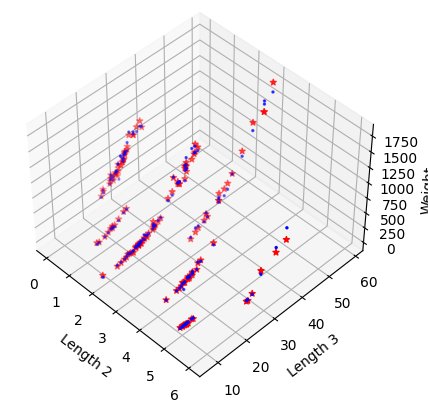

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X1, X2, Y, c='b', marker='o', s=2)
ax.scatter(X1, X2, PR2.predict(X), c='r', marker='*')
ax.view_init(elev=45, azim=-45)
ax.set_xlabel('Length 2')
ax.set_ylabel('Length 3')
ax.set_zlabel('Weight')
plt.show()

Se grafican los puntos originales del CSV y junto a las predicciones. Esto sobre las variables con mayor correlación con el peso.

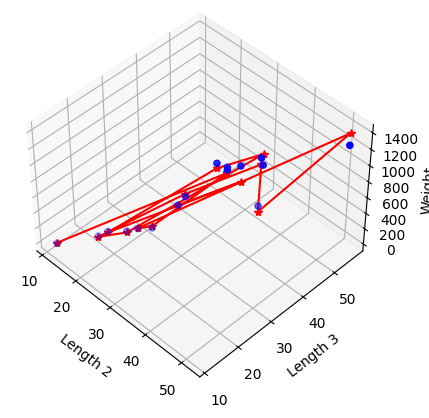

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_test.T[1], X_test.T[2], Y_test, c='b', marker='o')
ax.plot(X_test.T[1], X_test.T[2], PR4.predict(X_test), c='r', marker='*')
ax.view_init(elev=45, azim=-45)
ax.set_xlabel('Length 2')
ax.set_ylabel('Length 3')
ax.set_zlabel('Weight')
plt.show()

Se grafican los puntos originales del CSV y junto a las predicciones. Esto sobre la variable con la mayor correlación y las especies.

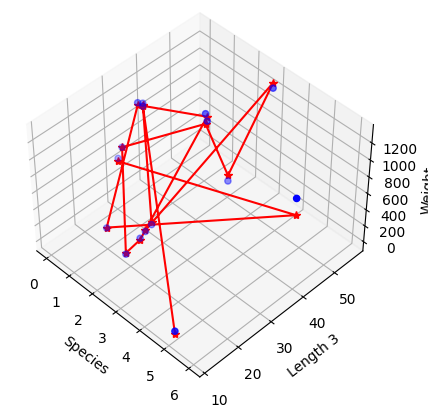

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_test.T[0], X_test.T[2], Y_test, c='b', marker='o')
ax.plot(X_test.T[0], X_test.T[2], PR2.predict(X_test), c='r', marker='*')
ax.view_init(elev=45, azim=-45)
ax.set_xlabel('Species')
ax.set_ylabel('Length 3')
ax.set_zlabel('Weight')
plt.show()